## 代码地址:https://github.com/NachoLiu1234/assignment/blob/master/project2/train.ipynb

项目链接: http://117.51.152.213:10578/waimai

效果展示: 
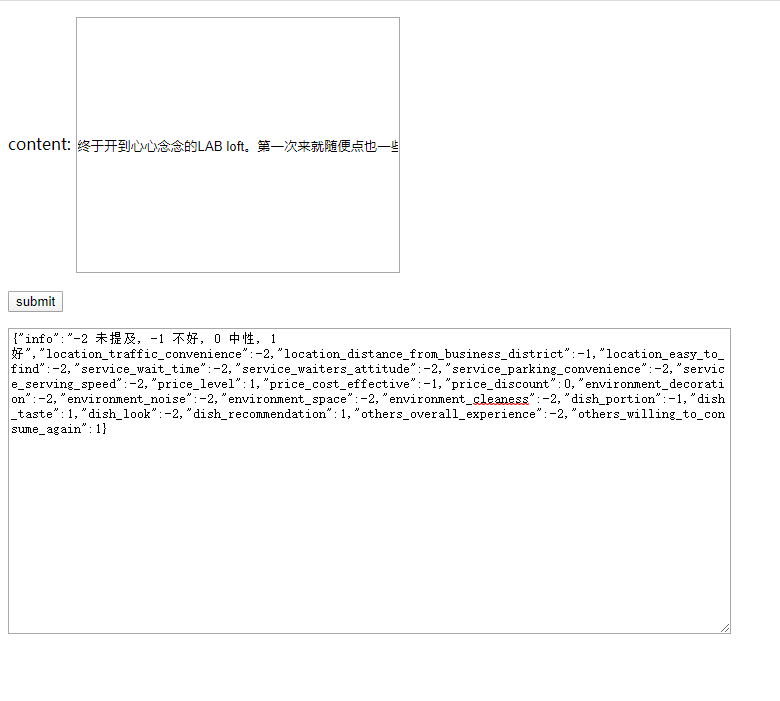

1. 标签: 这个文本细粒度的项目标签分布不均衡, 我通过给每个训练数据定一个权重来处理, 权重的计算 = 总的标签数量 / 该标签的数量

2. 模型: 一开始使用了3层双向lstm, 后来发现CPU速度比tesla v100还要快几倍, 因为lstm的输入取决于上一个输出, 所以无法利用GPU的大量核心的特点, 除非使用大量lstm, 但是大量lstm可能导致过拟合, 模型的泛化不好, 所以采用conv1d

3. 训练超参数: 考虑到20个标签训练时间较长, 所以减少了epoch的数量, 减少了模型深度, 减少了模型的参数, 使单个epoch需要的时间缩短. 因为之前有过这样的经验, 在训练数据时, 使用了SGD的0.001的学习率, 后来接近收敛, 又把学习率减到了1/5(0.0002)以后, loss瞬间下降了, 所以这次训练模型时, 我采用0.01训练10个epoch, 再用0.002训练5个epoch, 再用0.0002训练5个epoch

4. 衡量指标: 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import gensim, time
import pickle, json
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
validation_path = '/content/drive/My Drive/Colab Notebooks/project2/validation.pkl'
word2vec_path = '/content/drive/My Drive/Colab Notebooks/project2/cn.cbow.bin'
history_path = '/content/drive/My Drive/Colab Notebooks/project2/model/history_%s.json'
model_path = '/content/drive/My Drive/Colab Notebooks/project2/model/model_%s.tf'

to_categorical = {
    -2: np.array([1., 0., 0., 0.], dtype=np.float32),
    -1: np.array([0., 1., 0., 0.], dtype=np.float32),
    0: np.array([0., 0., 1., 0.], dtype=np.float32),
    1: np.array([0., 0., 0., 1.], dtype=np.float32),
}

columns = ['location_traffic_convenience',
   'location_distance_from_business_district', 'location_easy_to_find',
   'service_wait_time', 'service_waiters_attitude',
   'service_parking_convenience', 'service_serving_speed', 'price_level',
   'price_cost_effective', 'price_discount', 'environment_decoration',
   'environment_noise', 'environment_space', 'environment_cleaness',
   'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
   'others_overall_experience', 'others_willing_to_consume_again']

validation = pickle.load(open(validation_path, 'rb'))

validation_ground_truth = {k: validation[k].to_list() for k in columns}
output = columns[0]

batch_size = 8
truncate = 450
dimension = 300

validation = validation[['content', output]]
validation.columns = ['x', 'y']
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')
x_validation = validation['x'].to_list()
x_validation = [word2vec.wv[el]  for el in x_validation]
del word2vec

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [0]:
class CIFAR10Sequence(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size, class_weight=None):
      assert len(x) == len(y), '输入输出长度不匹配'

      self.x = x
      # self.y = tf.keras.utils.to_categorical(y, 4)
      self.y = [to_categorical[el] for el in y]
      self.batch_size = batch_size
      self.add = [np.zeros(300, dtype=np.float32)]
      self.truncate = 450
      self.dimension = 300
      self.sample_weight = None
      if class_weight:
        std = np.std([el for el in class_weight.values()])
        class_weight = {k: v / std for k, v in class_weight.items()}
        self.sample_weight = np.array([class_weight[el] for el in y])

    def __len__(self):
      return len(self.x) // self.batch_size

    def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
      batch_x = [np.append(el, self.add * (self.truncate - el.shape[0]), axis=0) if el.shape[0] < self.truncate else el for el in batch_x]
      batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]

      if self.sample_weight is None:
        return np.array(batch_x), np.array(batch_y)

      sample_weight = self.sample_weight[idx * self.batch_size: (idx + 1) * self.batch_size]
      return np.array(batch_x), np.array(batch_y), np.array(sample_weight)


In [0]:
columns = ['location_traffic_convenience',
   'location_distance_from_business_district', 'location_easy_to_find',
   'service_wait_time', 'service_waiters_attitude',
   'service_parking_convenience', 'service_serving_speed', 'price_level',
   'price_cost_effective', 'price_discount', 'environment_decoration',
   'environment_noise', 'environment_space', 'environment_cleaness',
   'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
   'others_overall_experience', 'others_willing_to_consume_again']

model_f1_score = []
model_precision = []
model_recall = []
micro_f1_score = []
micro_precision = []
micro_recall = []
macro_f1_score = []
macro_precision = []
macro_recall = []

for index, key in enumerate(columns):
    print(key)

    y_validation = validation_ground_truth[key]

    validation = CIFAR10Sequence(x_validation, y_validation, batch_size)
    
    model = tf.keras.models.load_model(model_path % key)
    
    ################################### 用model.evaluate 评估 ###################################
    
    history = model.evaluate(validation, verbose=2)
    precision = history[-2]
    recall = history[-1]
    print(f'model f1: {2 * precision * recall / (precision + recall)}, precision: {precision}, recall: {recall}')
    
    model_f1_score.append(2 * precision * recall / (precision + recall))
    model_precision.append(precision)
    model_recall.append(recall)
    ################################### 用model.predict + sklearn 评估 ###################################
    
    def get_predict_class(validataion, model):
        batch_size = 8
        
        def get_class(numpy_result):
            result = list(numpy_result).index(max(numpy_result)) - 2
            return result

        def convert2class(numpy_ground_truth):
            for k, v in to_categorical.items():
                if all(v == numpy_ground_truth):
                    return k
                
        ground_truth_all = []
        predict_result_all = []
        for validataion_batch in validataion:

            ground_truth = validataion_batch[1]
            ground_truth_class = [convert2class(el) for el in ground_truth]
            
            batch_result = model.predict(validataion_batch[0], batch_size=batch_size)
            predict_truth_class = []
            for i in range(batch_size):
                predict_truth_class.append(get_class(batch_result[i]))
            ground_truth_all.extend(ground_truth_class)
            predict_result_all.extend(predict_truth_class)
        return ground_truth_all, predict_result_all

    ground_truth_all, predict_result_all = get_predict_class(validation, model)
    
    f1 = f1_score( ground_truth_all, predict_result_all, average='macro' )
    p = precision_score(ground_truth_all, predict_result_all, average='macro')
    r = recall_score(ground_truth_all, predict_result_all, average='macro')
    print(f'macro f1: {f1}, precision: {p}, recall: {r}')

    macro_f1_score.append(f1)
    macro_precision.append(p)
    macro_recall.append(r)

    f1 = f1_score( ground_truth_all, predict_result_all, average='micro' )
    p = precision_score(ground_truth_all, predict_result_all, average='micro')
    r = recall_score(ground_truth_all, predict_result_all, average='micro')
    print(f'micro f1: {f1}, precision: {p}, recall: {r}')

    micro_f1_score.append(f1)
    micro_precision.append(p)
    micro_recall.append(r)
    print('#########################################################################################################\n')
    
    del model, history, ground_truth_all, predict_result_all

model_f1_score = sum(model_f1_score) / len(model_f1_score)
model_precision = sum(model_precision) / len(model_precision)
model_recall = sum(model_recall) / len(model_recall)
micro_f1_score = sum(micro_f1_score) / len(micro_f1_score)
micro_precision = sum(micro_precision) / len(micro_precision)
micro_recall = sum(micro_recall) / len(micro_recall)
macro_f1_score = sum(macro_f1_score) / len(macro_f1_score)
macro_precision = sum(macro_precision) / len(macro_precision)
macro_recall = sum(macro_recall) / len(macro_recall)

print(f'model average f1_score: {model_f1_score}')
print(f'model average precision: {model_precision}')
print(f'model average recall: {model_recall}')

print(f'micro average f1_score: {micro_f1_score}')
print(f'micro average precision: {micro_precision}')
print(f'micro average recall: {micro_recall}')

print(f'macro average f1_score: {macro_f1_score}')
print(f'macro average precision: {macro_precision}')
print(f'macro average recall: {macro_recall}')
time.sleep(2)

location_traffic_convenience
location_traffic_convenience
1875/1875 - 25s - loss: 0.5808 - categorical_accuracy: 0.6969 - auc_58: 0.9352 - precision_58: 0.9820 - recall_58: 0.6621
1875/1875 - 25s - loss: 0.5808 - categorical_accuracy: 0.6969 - auc_58: 0.9352 - precision_58: 0.9820 - recall_58: 0.6621
model f1: 0.7909532479590187, precision: 0.9820051193237305, recall: 0.6621333360671997
model f1: 0.7909532479590187, precision: 0.9820051193237305, recall: 0.6621333360671997


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macro f1: 0.24802397141206278, precision: 0.27753991107518083, recall: 0.4077976008580492
micro f1: 0.6969333333333333, precision: 0.6969333333333333, recall: 0.6969333333333333
#########################################################################################################

location_distance_from_business_district
macro f1: 0.24802397141206278, precision: 0.27753991107518083, recall: 0.4077976008580492
micro f1: 0.6969333333333333, precision: 0.6969333333333333, recall: 0.6969333333333333
#########################################################################################################

location_distance_from_business_district
1875/1875 - 25s - loss: 1.2761 - categorical_accuracy: 0.2662 - auc_60: 0.6131 - precision_60: 0.0125 - recall_60: 7.3333e-04
1875/1875 - 25s - loss: 1.2761 - categorical_accuracy: 0.2662 - auc_60: 0.6131 - precision_60: 0.0125 - recall_60: 7.3333e-04
model f1: 0.0013853031889642941, precision: 0.012485811486840248, recall: 0.000733333348762244
m

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macro f1: 0.37391146099892936, precision: 0.3513378427860774, recall: 0.4465175720493465
micro f1: 0.7989333333333334, precision: 0.7989333333333334, recall: 0.7989333333333334
#########################################################################################################

price_level
macro f1: 0.37391146099892936, precision: 0.3513378427860774, recall: 0.4465175720493465
micro f1: 0.7989333333333334, precision: 0.7989333333333334, recall: 0.7989333333333334
#########################################################################################################

price_level
1875/1875 - 25s - loss: 0.8976 - categorical_accuracy: 0.5997 - auc_72: 0.8609 - precision_72: 0.9186 - recall_72: 0.3919
1875/1875 - 25s - loss: 0.8976 - categorical_accuracy: 0.5997 - auc_72: 0.8609 - precision_72: 0.9186 - recall_72: 0.3919
model f1: 0.549439243712647, precision: 0.9185937643051147, recall: 0.3919333219528198
model f1: 0.549439243712647, precision: 0.9185937643051147, recall: 0.3919333

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macro f1: 0.4467134671334331, precision: 0.4042598841182816, recall: 0.5423151739206101
micro f1: 0.5997333333333333, precision: 0.5997333333333333, recall: 0.5997333333333333
#########################################################################################################

price_cost_effective
macro f1: 0.4467134671334331, precision: 0.4042598841182816, recall: 0.5423151739206101
micro f1: 0.5997333333333333, precision: 0.5997333333333333, recall: 0.5997333333333333
#########################################################################################################

price_cost_effective
1875/1875 - 25s - loss: 0.8003 - categorical_accuracy: 0.7575 - auc_74: 0.8958 - precision_74: 0.9185 - recall_74: 0.5537
1875/1875 - 25s - loss: 0.8003 - categorical_accuracy: 0.7575 - auc_74: 0.8958 - precision_74: 0.9185 - recall_74: 0.5537
model f1: 0.690928788573714, precision: 0.9185004830360413, recall: 0.5537333488464355
model f1: 0.690928788573714, precision: 0.9185004830360413, r

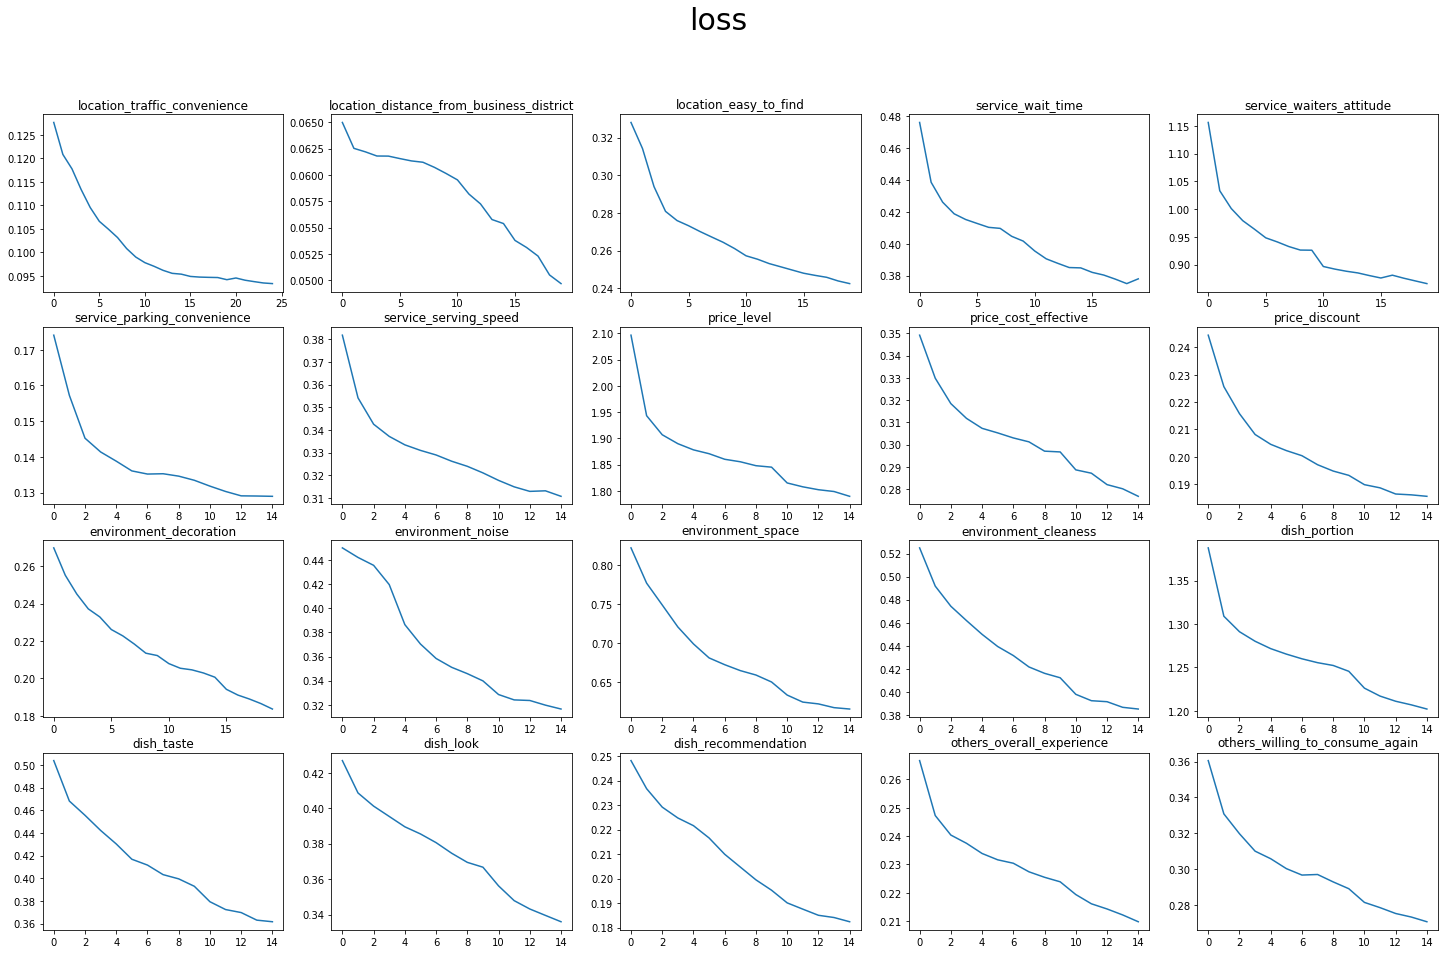

In [15]:
columns = ['location_traffic_convenience',
   'location_distance_from_business_district', 'location_easy_to_find',
   'service_wait_time', 'service_waiters_attitude',
   'service_parking_convenience', 'service_serving_speed', 'price_level',
   'price_cost_effective', 'price_discount', 'environment_decoration',
   'environment_noise', 'environment_space', 'environment_cleaness',
   'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
   'others_overall_experience', 'others_willing_to_consume_again']

plt.figure(figsize=(25,15))
plt.suptitle('loss', fontsize=30)

for index, key in enumerate(columns):
  loss_path = history_path % key
  with open(loss_path, 'r', -1, 'utf8') as f:
    history = f.readlines()
  history = [json.loads(el)['loss'] for el in history if el.strip()]
  history = sum(history, [])
  plt.subplot(4,5,index+1, title=key)
  plt.plot(range(len(history)), history)
